# Pokémon Winrate Analysis - VGC 2025

This notebook analyzes the winrates of Pokémon in VGC 2025 format.
We'll look at:
1. Overall Pokémon winrates (regardless of setup)
2. Specific setup winrates (with specific moves, items, and tera types)

In [1]:
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Initialize Spark Session

In [2]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Pokemon Winrate Analysis") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

We will load in a subset of data first to see what it looks like

In [4]:
# Path to the parquet files
parquet_path = "../../data/replays/gen9vgc2025regg/pre_processed/replays/2025-03-24_03-13-20"

# Load the data
battles_df = spark.read.parquet(parquet_path).limit(1000)

print(f"Success! Found {battles_df.count()} records")

# Show the schema
battles_df.printSchema()

Success! Found 1000 records
root
 |-- id: string (nullable = true)
 |-- format: string (nullable = true)
 |-- players: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- uploadtime: long (nullable = true)
 |-- views: long (nullable = true)
 |-- formatid: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- private: long (nullable = true)
 |-- password: integer (nullable = true)
 |-- team_sheets_accepted: boolean (nullable = true)
 |-- p1_pokemon_data_open_team: map (nullable = true)
 |    |-- key: string
 |    |-- value: struct (valueContainsNull = true)
 |    |    |-- item: string (nullable = true)
 |    |    |-- ability: string (nullable = true)
 |    |    |-- moves: string (nullable = true)
 |    |    |-- tera_type: string (nullable = true)
 |-- p2_pokemon_data_open_team: map (nullable = true)
 |    |-- key: string
 |    |-- value: struct (valueContainsNull = true)
 |    |    |-- item: string (nullable = true)
 |    |    |-- ability: string (

In [5]:
# Convert 5 rows to pandas and display
sample_df = battles_df.limit(5).toPandas()
sample_df

,id,format,players,uploadtime,views,formatid,rating,private,password,team_sheets_accepted,...,weather,forfeit,status_effects,winner,player1_pokemon_moves,player2_pokemon_moves,player1_pokemon_items,player2_pokemon_items,player1_pokemon_tera,player2_pokemon_tera
0,gen9vgc2025regg-2254660261,[Gen 9] VGC 2025 Reg G,"[Camilo997, JNEST]",1733076626,4,gen9vgc2025regg,NaN,0,NaN,False,...,,,,JNEST\n,"{'Koraidon': ['Flame Charge', 'Collision Cours...","{'Calyrex': ['Astral Barrage', 'Protect'], 'Ri...",{'Incineroar': ['Sitrus Berry']},"{'Calyrex': ['Covert Cloak'], 'Raging Bolt': [...",{'Koraidon': 'Fire'},{'Raging Bolt': 'Electric'}
1,gen9vgc2025regg-2254667385,[Gen 9] VGC 2025 Reg G,"[HyeheahHot, tedidn]",1733077388,6,gen9vgc2025regg,1000.0,0,NaN,False,...,,,,tedidn\n,"{'Sawsbuck': ['Swords Dance', 'Headbutt'], 'Wi...","{'Primal Ruler': ['Flare Blitz'], 'Cordyceps':...","{'Sawsbuck': ['Focus Sash '], 'Wigglytuff': ['...",None,None,{'Primal Ruler': 'Fire'}
2,gen9vgc2025regg-2254671307,[Gen 9] VGC 2025 Reg G,"[lordaezen, tedidn]",1733077887,5,gen9vgc2025regg,1047.0,0,NaN,False,...,,,,lordaezen\n,"{'Calyrex': ['Calm Mind', 'Astral Barrage', 'P...","{'Benicia': ['Moonblast'], 'Primal Ruler': ['F...",{'Roaring Moon': ['Booster Energy ']},{'Arlo': ['Life Orb']},{'Calyrex': 'Fairy'},{'Primal Ruler': 'Fire'}
3,gen9vgc2025regg-2254672855,[Gen 9] VGC 2025 Reg G,"[xelax97, niesieler]",1733078468,12,gen9vgc2025regg,NaN,0,NaN,False,...,,,,xelax97\n,"{'Pelipper': ['Wide Guard', 'Hurricane', 'Tail...","{'Kyogre': ['Origin Pulse', 'Protect'], 'Amoon...",None,None,{'Archaludon': 'Fighting'},None
4,gen9vgc2025regg-2254682108,[Gen 9] VGC 2025 Reg G,"[bieiup, Gurrasnurra5]",1733079079,2,gen9vgc2025regg,NaN,0,NaN,False,...,,,,Gurrasnurra5\n,"{'Dewgong': ['Fake Out'], 'Lunala': ['Moongeis...","{'Amoonguss': ['Spore'], 'Gholdengo': ['Make I...",{'Lunala': ['Power Herb ']},None,{'Lunala': 'Normal'},{'Gholdengo': 'Normal'}


We will begin exploring the data by first taking a look at the winners.

We will need a little bit of cleaning on our data since there are some bad characters (ie new line characters) making things messy.

In [6]:
# We'll create a view to make SQL queries more readable
battles_df.createOrReplaceTempView("battles")



# Let's first look at the winning values to understand their format
winner_analysis = spark.sql("""
    SELECT 
        id, 
        winner, 
        players,
        regexp_replace(winner, '\\\\s+', '') AS cleaned_winner,
        regexp_replace(players[0], '\\\\s+', '') AS cleaned_player1,
        regexp_replace(players[1], '\\\\s+', '') AS cleaned_player2
    FROM battles
    LIMIT 10
""")

winner_analysis.show(truncate=False)


+--------------------------+------------------+---------------------------------+----------------+---------------+----------------+
|id                        |winner            |players                          |cleaned_winner  |cleaned_player1|cleaned_player2 |
+--------------------------+------------------+---------------------------------+----------------+---------------+----------------+
|gen9vgc2025regg-2254660261|JNEST\n           |[Camilo997, JNEST]               |JNEST           |Camilo997      |JNEST           |
|gen9vgc2025regg-2254667385|tedidn\n          |[HyeheahHot, tedidn]             |tedidn          |HyeheahHot     |tedidn          |
|gen9vgc2025regg-2254671307|lordaezen\n       |[lordaezen, tedidn]              |lordaezen       |lordaezen      |tedidn          |
|gen9vgc2025regg-2254672855|xelax97\n         |[xelax97, niesieler]             |xelax97         |xelax97        |niesieler       |
|gen9vgc2025regg-2254682108|Gurrasnurra5\n    |[bieiup, Gurrasnurra5]       

Now that we know how to clean the data, lets do some exploring on top wins.

In [7]:
# Now let's modify our approach to use regexp_replace to handle whitespace and newlines
winning_pokemon_df = spark.sql("""
    -- First, create a temporary view with just the winner information
    WITH winners AS (
        SELECT 
            id,
            CASE
                -- Using regexp_replace to remove all whitespace (including newlines)
                WHEN regexp_replace(winner, '\\\\s+', '') = regexp_replace(players[0], '\\\\s+', '') THEN 'p1'
                WHEN regexp_replace(winner, '\\\\s+', '') = regexp_replace(players[1], '\\\\s+', '') THEN 'p2'
                WHEN lower(regexp_replace(winner, '\\\\s+', '')) = 'p1' THEN 'p1'
                WHEN lower(regexp_replace(winner, '\\\\s+', '')) = 'p2' THEN 'p2'
                ELSE NULL
            END AS winning_player
        FROM battles
        WHERE winner IS NOT NULL
    )
    
    -- Combine all winning Pokémon, regardless of player
    SELECT 
        species,
        COUNT(*) AS win_count
    FROM (
        -- Extract player 1's winning Pokémon when player 1 won
        SELECT 
            species
        FROM battles b
        JOIN winners w ON b.id = w.id
        LATERAL VIEW EXPLODE(player1_full_team) AS species
        WHERE w.winning_player = 'p1'
        
        UNION ALL
        
        -- Extract player 2's winning Pokémon when player 2 won
        SELECT 
            species
        FROM battles b
        JOIN winners w ON b.id = w.id
        LATERAL VIEW EXPLODE(player2_full_team) AS species
        WHERE w.winning_player = 'p2'
    ) all_winning_pokemon
    GROUP BY species
""")

# Check the results
print(f"Total unique winning Pokémon: {winning_pokemon_df.count()}")
winning_pokemon_df.orderBy(F.col("win_count").desc()).show(10)

Total unique winning Pokémon: 315
+------------+---------+
|     species|win_count|
+------------+---------+
|     Urshifu|      482|
|  Incineroar|      277|
|   Rillaboom|      237|
|   Farigiraf|      195|
|Flutter Mane|      194|
|    Tornadus|      191|
|  Whimsicott|      191|
| Calyrex-Ice|      191|
| Raging Bolt|      183|
|  Iron Hands|      164|
+------------+---------+
only showing top 10 rows



In [8]:
# Import the Window class
from pyspark.sql import Window

# Count total occurrences of each Pokémon for denominator in winrate calculation
total_pokemon_df = spark.sql("""
    SELECT 
        species,
        COUNT(*) as total_appearances
    FROM (
        -- Count all player 1's Pokémon
        SELECT 
            species
        FROM battles
        LATERAL VIEW EXPLODE(player1_full_team) AS species
        
        UNION ALL
        
        -- Count all player 2's Pokémon
        SELECT 
            species
        FROM battles
        LATERAL VIEW EXPLODE(player2_full_team) AS species
    ) all_pokemon
    GROUP BY species
""")

# Check the results
print(f"Total unique Pokémon: {total_pokemon_df.count()}")
total_pokemon_df.orderBy(F.col("total_appearances").desc()).show(16)

# Define an empty window spec to sum over the entire dataset
windowSpec = Window.partitionBy(F.lit(1))  # A constant literal to create a single partition

# Join with win counts to calculate winrate
winrates_df = winning_pokemon_df.join(total_pokemon_df, "species") \
    .withColumn("winrate", F.col("win_count") / F.col("total_appearances")) \
    .withColumn("total_sum", F.sum("total_appearances").over(windowSpec)) \
    .withColumn("usage_rate", (F.col("total_appearances") / F.col("total_sum") * 100))\
    .drop("total_sum")  # Drop the intermediate column

# Filter for Pokémon with minimum appearances to avoid statistical noise
min_appearances = 50  # Adjust as needed
winrates_filtered_df = winrates_df.filter(F.col("total_appearances") >= min_appearances) \
    .orderBy(F.col("winrate").desc())

# Show the top Pokémon by winrate
print(f"Top Pokémon by winrate (minimum {min_appearances} appearances):")
winrates_filtered_df.show(16)

Total unique Pokémon: 396
+-------------------+-----------------+
|            species|total_appearances|
+-------------------+-----------------+
|            Urshifu|              893|
|         Incineroar|              563|
|          Rillaboom|              484|
|           Tornadus|              381|
|          Farigiraf|              378|
|       Flutter Mane|              372|
|         Whimsicott|              354|
|        Raging Bolt|              348|
|        Calyrex-Ice|              315|
|           Miraidon|              310|
|     Calyrex-Shadow|              305|
|         Iron Hands|              282|
|          Amoonguss|              270|
|         Indeedee-F|              249|
|Ogerpon-Hearthflame|              244|
|          Chien-Pao|              229|
+-------------------+-----------------+
only showing top 16 rows

Top Pokémon by winrate (minimum 50 appearances):
+-------------------+---------+-----------------+------------------+------------------+
|          

Lets visualize this

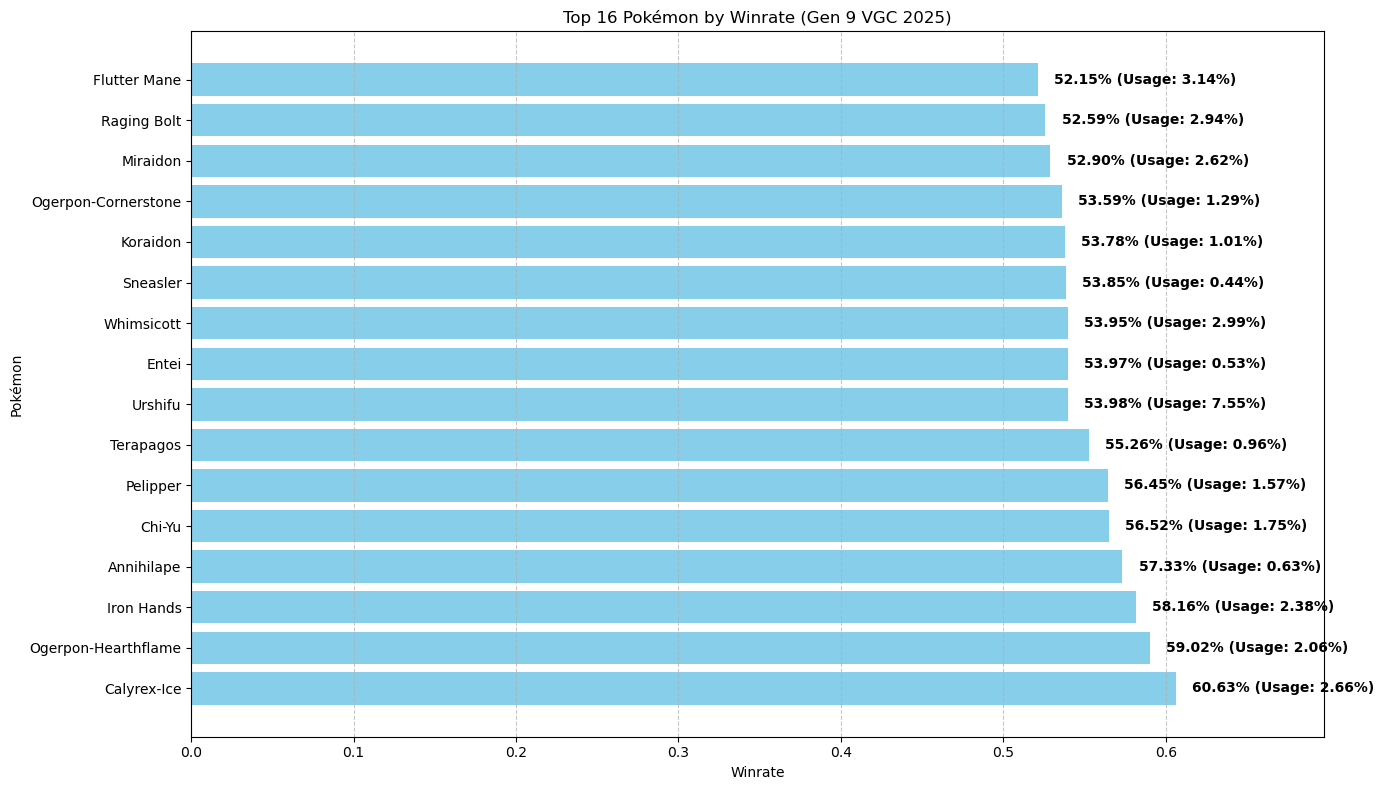

In [9]:
# First, let's create a better visualization for our current winrate results
# Convert to pandas for nicer visualization
top_pokemon_df = winrates_filtered_df.limit(16).toPandas()

# Create a bar chart for the current winrate analysis
plt.figure(figsize=(14, 8))
bars = plt.barh(top_pokemon_df['species'], top_pokemon_df['winrate'], color='skyblue')

# Add data labels with both winrate percentage and usage rate
for bar in bars:
    width = bar.get_width()
    idx = bars.index(bar)
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{width:.2%} (Usage: {top_pokemon_df.iloc[idx]["usage_rate"]:.2f}%)', 
             va='center', ha='left', fontweight='bold')

plt.xlabel('Winrate')
plt.ylabel('Pokémon')
plt.title('Top 16 Pokémon by Winrate (Gen 9 VGC 2025)')
plt.xlim(0, max(top_pokemon_df['winrate']) * 1.15)  # Add padding for labels
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Lets now check the open teamsheet data. First the win rates:

In [10]:
# Now let's analyze Pokémon with team sheets accepted
# This will focus on specific setups (moves, items, tera types)

# Get data for battles with team sheets accepted
open_team_pokemon_df = spark.sql("""
    -- First, get battles with team sheets accepted
    WITH team_sheet_battles AS (
        SELECT 
            id,
            regexp_replace(winner, '\\\\s+', '') AS cleaned_winner,
            regexp_replace(players[0], '\\\\s+', '') AS cleaned_player1,
            regexp_replace(players[1], '\\\\s+', '') AS cleaned_player2,
            p1_pokemon_data_open_team,
            p2_pokemon_data_open_team
        FROM battles
        WHERE team_sheets_accepted = true
    ),
    
    -- Determine the winning player
    winners AS (
        SELECT 
            id,
            CASE
                WHEN cleaned_winner = cleaned_player1 THEN 'p1'
                WHEN cleaned_winner = cleaned_player2 THEN 'p2'
                WHEN lower(cleaned_winner) = 'p1' THEN 'p1'
                WHEN lower(cleaned_winner) = 'p2' THEN 'p2'
                ELSE NULL
            END AS winning_player
        FROM team_sheet_battles
        WHERE cleaned_winner IS NOT NULL
    ),
    
    -- Extract winning Pokémon details
    winning_pokemon AS (
        -- Player 1's winning Pokémon
        SELECT 
            b.id,
            pokemon_key AS species,
            pokemon_value.item AS item,
            pokemon_value.ability AS ability,
            pokemon_value.moves AS moves,
            pokemon_value.tera_type AS tera_type,
            1 AS win_count
        FROM team_sheet_battles b
        JOIN winners w ON b.id = w.id
        LATERAL VIEW explode(p1_pokemon_data_open_team) pokemon_data AS pokemon_key, pokemon_value
        WHERE w.winning_player = 'p1'
        
        UNION ALL
        
        -- Player 2's winning Pokémon
        SELECT 
            b.id,
            pokemon_key AS species,
            pokemon_value.item AS item,
            pokemon_value.ability AS ability,
            pokemon_value.moves AS moves,
            pokemon_value.tera_type AS tera_type,
            1 AS win_count
        FROM team_sheet_battles b
        JOIN winners w ON b.id = w.id
        LATERAL VIEW explode(p2_pokemon_data_open_team) pokemon_data AS pokemon_key, pokemon_value
        WHERE w.winning_player = 'p2'
    ),
    
    -- Extract all Pokémon with team sheets
    all_pokemon AS (
        -- Player 1's Pokémon
        SELECT 
            pokemon_key AS species,
            pokemon_value.item AS item,
            pokemon_value.ability AS ability,
            pokemon_value.moves AS moves,
            pokemon_value.tera_type AS tera_type,
            1 AS appearance_count
        FROM team_sheet_battles
        LATERAL VIEW explode(p1_pokemon_data_open_team) pokemon_data AS pokemon_key, pokemon_value
        
        UNION ALL
        
        -- Player 2's Pokémon
        SELECT 
            pokemon_key AS species,
            pokemon_value.item AS item,
            pokemon_value.ability AS ability,
            pokemon_value.moves AS moves,
            pokemon_value.tera_type AS tera_type,
            1 AS appearance_count
        FROM team_sheet_battles
        LATERAL VIEW explode(p2_pokemon_data_open_team) pokemon_data AS pokemon_key, pokemon_value
    )
    
    -- Aggregate wins and appearances for each unique setup
    SELECT
        species,
        item,
        ability,
        moves,
        tera_type,
        SUM(win_count) AS win_count
    FROM winning_pokemon
    GROUP BY species, item, ability, moves, tera_type
""")

# Check the results
print(f"Total unique Pokémon: {open_team_pokemon_df.count()}")
open_team_pokemon_df.orderBy(F.col("win_count").desc()).show(16)

Total unique Pokémon: 364
+--------------------+---------------+--------------+--------------------+---------+---------+
|             species|           item|       ability|               moves|tera_type|win_count|
+--------------------+---------------+--------------+--------------------+---------+---------+
|         Calyrex-Ice|    ClearAmulet|AsOneGlastrier|GlacialLance,High...|     Fire|        8|
|           Rillaboom|    AssaultVest|   GrassySurge|GrassyGlide,WoodH...|     Fire|        6|
|           Amoonguss|    RockyHelmet|   Regenerator|RagePowder,Spore,...|    Water|        5|
|          Incineroar|  SafetyGoggles|    Intimidate|FakeOut,KnockOff,...|    Ghost|        5|
|           Farigiraf|    SitrusBerry|     ArmorTail|TrickRoom,FoulPla...|    Water|        5|
|         Raging Bolt|    AssaultVest|Protosynthesis|Thunderbolt,Draco...| Electric|        5|
|Urshifu-Rapid-Strike|    ChoiceScarf|    UnseenFist|SurgingStrikes,Cl...|    Water|        5|
|          Incineroar|  

Lets get the appearance rate:

In [11]:
# Get total appearances for each setup
# Get total appearances for each setup
open_team_total_df = spark.sql("""
    WITH team_sheet_battles AS (
        SELECT 
            id,
            p1_pokemon_data_open_team,
            p2_pokemon_data_open_team
        FROM battles
        WHERE team_sheets_accepted = true
    ),
    
    all_pokemon AS (
        -- Player 1's Pokémon
        SELECT 
            pokemon_key AS species,
            pokemon_value.item AS item,
            pokemon_value.ability AS ability,
            pokemon_value.moves AS moves,
            pokemon_value.tera_type AS tera_type,
            1 AS appearance_count
        FROM team_sheet_battles
        LATERAL VIEW explode(p1_pokemon_data_open_team) pokemon_data AS pokemon_key, pokemon_value
        
        UNION ALL
        
        -- Player 2's Pokémon
        SELECT 
            pokemon_key AS species,
            pokemon_value.item AS item,
            pokemon_value.ability AS ability,
            pokemon_value.moves AS moves,
            pokemon_value.tera_type AS tera_type,
            1 AS appearance_count
        FROM team_sheet_battles
        LATERAL VIEW explode(p2_pokemon_data_open_team) pokemon_data AS pokemon_key, pokemon_value
    )
    
    -- Count appearances for each unique setup
    SELECT
        species,
        item,
        ability,
        moves,
        tera_type,
        SUM(appearance_count) AS total_appearances
    FROM all_pokemon
    GROUP BY species, item, ability, moves, tera_type
""")

# Check the results
print(f"Total unique Pokémon: {open_team_total_df.count()}")
open_team_total_df.orderBy(F.col("total_appearances").desc()).show(16)

Total unique Pokémon: 665
+--------------------+---------------+---------------+--------------------+---------+-----------------+
|             species|           item|        ability|               moves|tera_type|total_appearances|
+--------------------+---------------+---------------+--------------------+---------+-----------------+
|         Calyrex-Ice|    ClearAmulet| AsOneGlastrier|GlacialLance,High...|     Fire|               10|
| Ogerpon-Hearthflame|HearthflameMask|    MoldBreaker|IvyCudgel,WoodHam...|     Fire|                9|
|Urshifu-Rapid-Strike|    ChoiceScarf|     UnseenFist|SurgingStrikes,Cl...|    Water|                8|
|Urshifu-Rapid-Strike|    ChoiceScarf|     UnseenFist|SurgingStrikes,Cl...|    Water|                8|
|          Incineroar|  SafetyGoggles|     Intimidate|KnockOff,WillOWis...|    Ghost|                7|
| Ogerpon-Cornerstone|CornerstoneMask|         Sturdy|IvyCudgel,PowerWh...|     Rock|                7|
|      Calyrex-Shadow|        LifeOrb|

So the current issue is that moves can be in any order, which will mess up some calculations. The order of the moves doesn't matter, what matters is that they are the same moves. So we will sort the array of the moves so if a pokemon has the same moves it will all match up.

In [16]:
# Standardize moves by converting comma-separated strings to sorted arrays
from pyspark.sql.functions import split, sort_array, array_join, col, collect_list, sum as spark_sum


# Function to standardize move ordering
def standardize_moves(df):
    return df.withColumn(
        "moves_array", split(col("moves"), ",")
    ).withColumn(
        "sorted_moves_array", sort_array("moves_array")
    ).withColumn(
        "standardized_moves", array_join("sorted_moves_array", ",")
    )

# Apply standardization to both dataframes
open_team_pokemon_std = standardize_moves(open_team_pokemon_df)
open_team_total_std = standardize_moves(open_team_total_df)

# Deduplicate winning Pokémon by grouping by standardized properties 
# This consolidates win counts for Pokémon with the same moves in different orders
win_pokemon_deduped = open_team_pokemon_std.groupBy(
    "species", "item", "ability", "tera_type", "standardized_moves", "sorted_moves_array"
).agg(
    spark_sum("win_count").alias("win_count")
)

# Deduplicate all Pokémon appearances similarly
all_pokemon_deduped = open_team_total_std.groupBy(
    "species", "item", "ability", "tera_type", "standardized_moves", "sorted_moves_array"
).agg(
    spark_sum("total_appearances").alias("total_appearances")
)

# Register temporary views for SQL joining
win_pokemon_deduped.createOrReplaceTempView("win_pokemon_deduped")
all_pokemon_deduped.createOrReplaceTempView("all_pokemon_deduped")

# Join the data with standardized moves - this ensures move order doesn't matter
# and we don't have duplicate entries for the same move set
team_data_matched = spark.sql("""
    SELECT
        w.species,
        w.item,
        w.ability,
        w.tera_type,
        w.sorted_moves_array as sorted_moves,
        w.standardized_moves,
        w.win_count,
        a.total_appearances,
        w.win_count / a.total_appearances as setup_winrate
    FROM win_pokemon_deduped w
    JOIN all_pokemon_deduped a
    ON w.species = a.species
        AND w.item = a.item
        AND w.ability = a.ability
        AND w.tera_type = a.tera_type
        AND w.standardized_moves = a.standardized_moves
""")

# Show the results, filtered and sorted
filtered_results = team_data_matched.filter(col("total_appearances") >= 5).orderBy(col("setup_winrate").desc())

# Display the results
filtered_results.limit(16).toPandas()

,species,item,ability,tera_type,sorted_moves,standardized_moves,win_count,total_appearances,setup_winrate
0,Incineroar,RockyHelmet,Intimidate,Ghost,"[FakeOut, KnockOff, PartingShot, WillOWisp]","FakeOut,KnockOff,PartingShot,WillOWisp",7,8,0.875000
1,Urshifu-Rapid-Strike,FocusSash,UnseenFist,Stellar,"[AquaJet, CloseCombat, Detect, SurgingStrikes]","AquaJet,CloseCombat,Detect,SurgingStrikes",6,7,0.857143
2,Farigiraf,SitrusBerry,ArmorTail,Water,"[FoulPlay, HelpingHand, Psychic, TrickRoom]","FoulPlay,HelpingHand,Psychic,TrickRoom",5,6,0.833333
3,Raging Bolt,AssaultVest,Protosynthesis,Electric,"[DracoMeteor, Snarl, Thunderbolt, Thunderclap]","DracoMeteor,Snarl,Thunderbolt,Thunderclap",6,8,0.750000
4,Amoonguss,RockyHelmet,Regenerator,Water,"[PollenPuff, Protect, RagePowder, Spore]","PollenPuff,Protect,RagePowder,Spore",6,8,0.750000
5,Calyrex-Ice,ClearAmulet,AsOneGlastrier,Fire,"[GlacialLance, HighHorsepower, Protect, TrickR...","GlacialLance,HighHorsepower,Protect,TrickRoom",12,16,0.750000
6,Urshifu-Rapid-Strike,MysticWater,UnseenFist,Water,"[AquaJet, CloseCombat, Detect, SurgingStrikes]","AquaJet,CloseCombat,Detect,SurgingStrikes",4,6,0.666667
7,Incineroar,SafetyGoggles,Intimidate,Ghost,"[FakeOut, FlareBlitz, KnockOff, PartingShot]","FakeOut,FlareBlitz,KnockOff,PartingShot",4,6,0.666667
8,Urshifu-Rapid-Strike,ChoiceScarf,UnseenFist,Water,"[AquaJet, CloseCombat, SurgingStrikes, Uturn]","AquaJet,CloseCombat,SurgingStrikes,Uturn",4,6,0.666667
9,Landorus,ChoiceScarf,SheerForce,Ghost,"[EarthPower, SandsearStorm, SludgeBomb, Uturn]","EarthPower,SandsearStorm,SludgeBomb,Uturn",5,8,0.625000


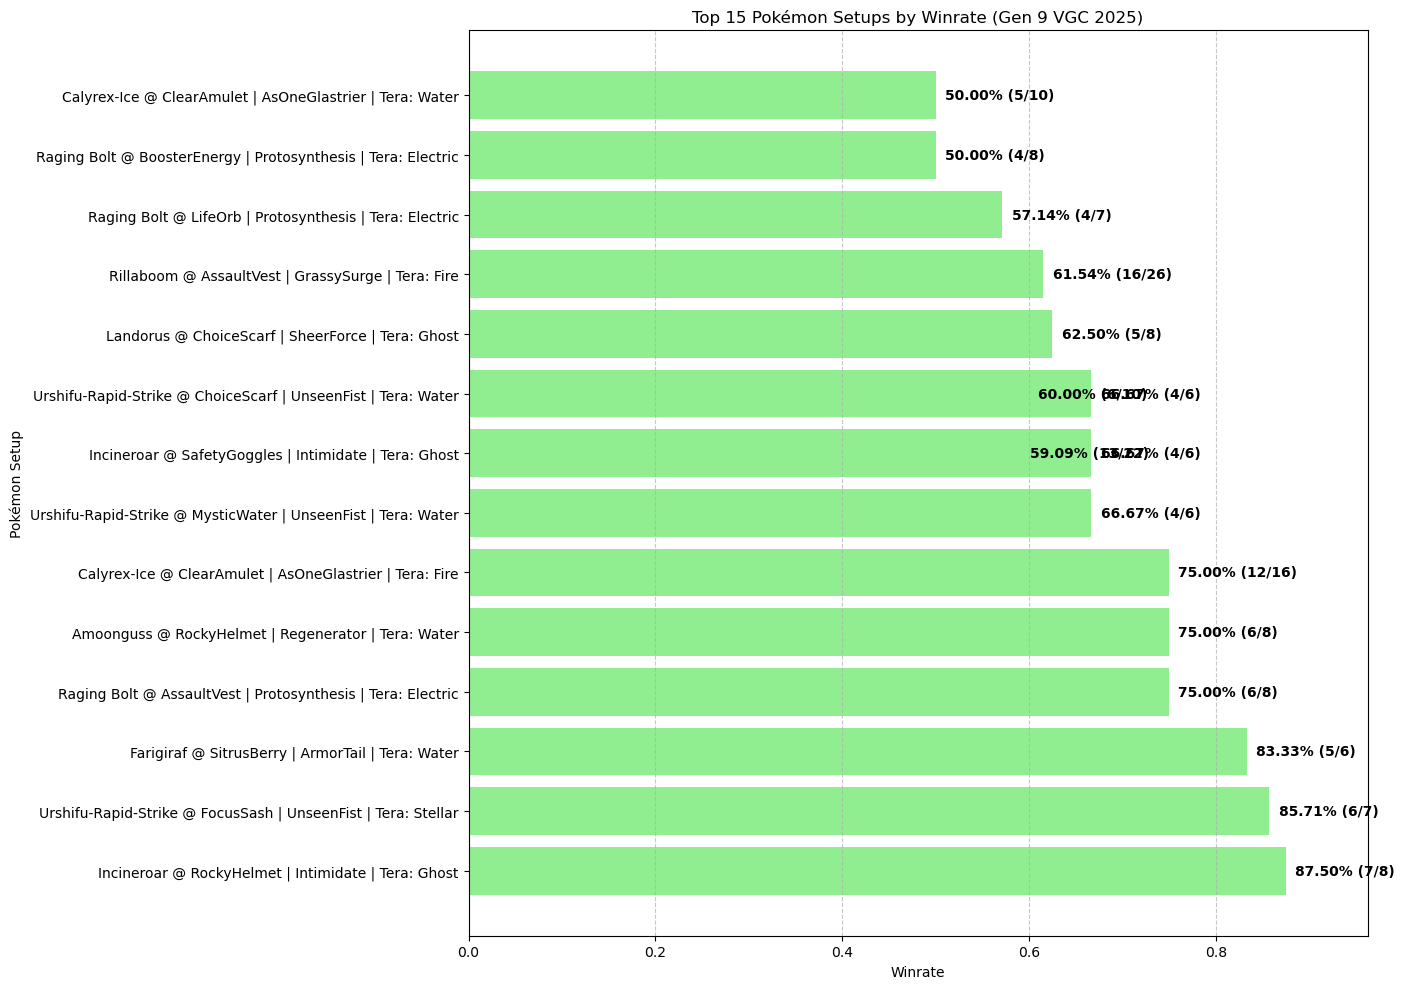

In [17]:
# Create a visualization of the top setups
import matplotlib.pyplot as plt

top_data = filtered_results.limit(16).toPandas()

# Format the setup info for display
def format_setup(row):
    moves_str = ", ".join([str(move) for move in row["sorted_moves"]])
    return f"{row['species']} @ {row['item']} | {row['ability']} | Tera: {row['tera_type']}"


top_data['formatted_setup'] = top_data.apply(format_setup, axis=1)

# Create the visualization
plt.figure(figsize=(14, 10))
bars = plt.barh(top_data['formatted_setup'], top_data['setup_winrate'], color='lightgreen')

# Add data labels
for bar in bars:
    width = bar.get_width()
    idx = bars.index(bar)
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{width:.2%} ({int(top_data.iloc[idx]["win_count"])}/{int(top_data.iloc[idx]["total_appearances"])})', 
             va='center', ha='left', fontweight='bold')

plt.xlabel('Winrate')
plt.ylabel('Pokémon Setup')
plt.title('Top 15 Pokémon Setups by Winrate (Gen 9 VGC 2025)')
plt.xlim(0, max(top_data['setup_winrate']) * 1.1)  # Add padding for labels
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()